In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

# Add soundfile for audio file writing
import soundfile as sf

# Set environment variable to disable OneDNN optimizations
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Enable mixed precision training for faster computation
import tensorflow as tf
try:
    # Only for GPUs that support it
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision training enabled")
except:
    print("Mixed precision not supported, using default precision")

from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Mixed precision training enabled


Processing all actor data...
Found 1 actor folders: ['Train']
Processing batch of actors: ['Train']
Processed 1140 files from actors ['Train']
Total number of audio files: 1140
Number of unique speakers: 19
Actor folders found: ['Train']
Emotions in the dataset: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']


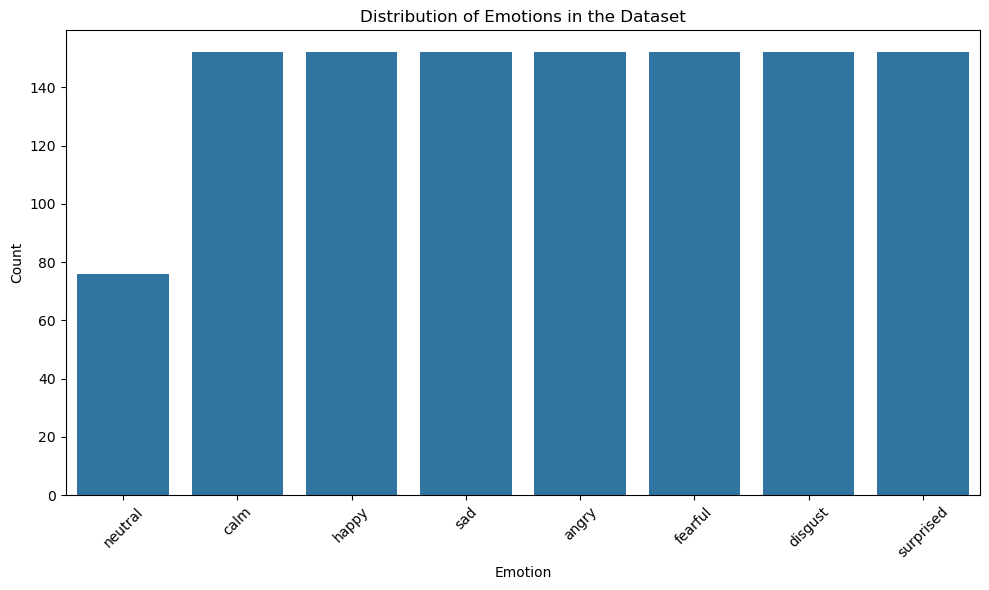

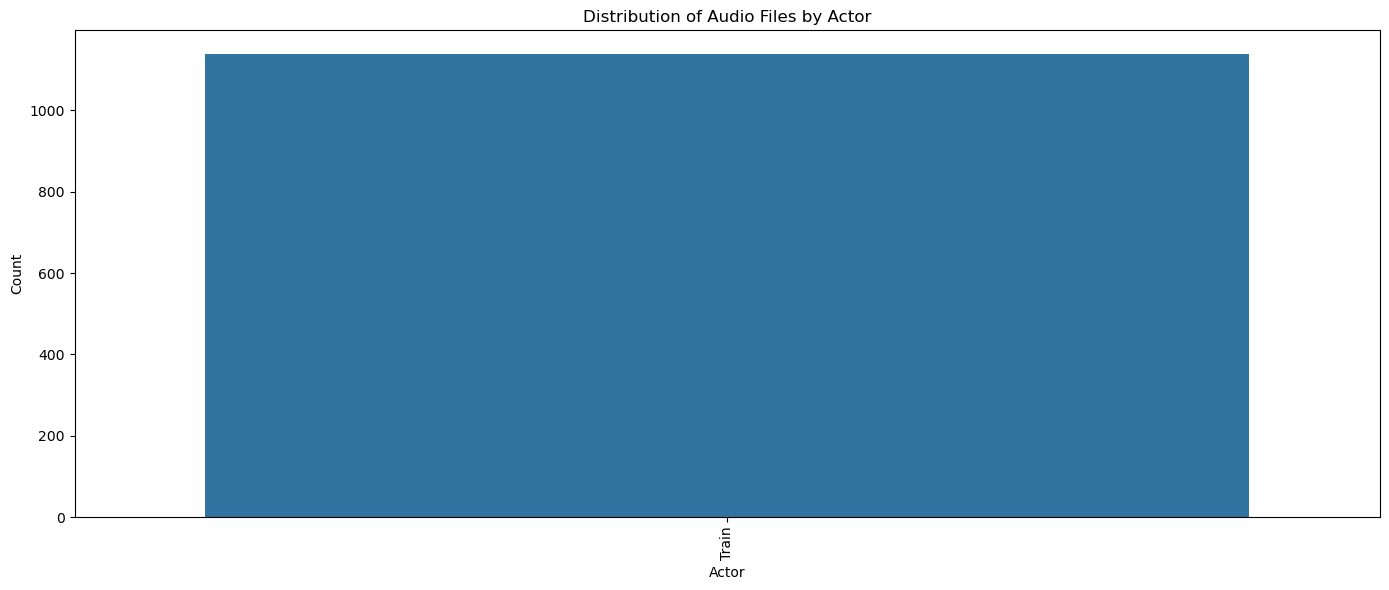

Extracting features in batches...
Processing batch 1/18
Processing batch 2/18
Processing batch 3/18
Processing batch 4/18
Processing batch 5/18
Processing batch 6/18
Processing batch 7/18
Processing batch 8/18
Processing batch 9/18
Processing batch 10/18
Processing batch 11/18
Processing batch 12/18
Processing batch 13/18
Processing batch 14/18
Processing batch 15/18
Processing batch 16/18
Processing batch 17/18
Processing batch 18/18
Detected 8 emotion classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [11]:
# Define the path to your dataset
data_path = r"C:\Users\manas\Downloads\Train" # Base path containing all actor folders

# Function to get all actor folders
def get_all_actors(base_path):
    actor_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    return actor_folders

# Process all actor data in batches
def process_all_actors(base_path, batch_size=5):
    """
    Process all actors in the dataset in batches
    
    Args:
        base_path: Path to the dataset containing actor folders
        batch_size: Number of actors to process in each batch
    
    Returns:
        Combined metadata dataframe with all actors' data
    """
    # Get all actor folders
    all_actors = get_all_actors(base_path)
    print(f"Found {len(all_actors)} actor folders: {all_actors}")
    
    all_metadata = []
    
    # Process actors in batches
    for i in range(0, len(all_actors), batch_size):
        batch_actors = all_actors[i:i+batch_size]
        print(f"Processing batch of actors: {batch_actors}")
        
        batch_metadata = []
        for actor in batch_actors:
            actor_path = os.path.join(base_path, actor)
            for root, dirs, files in os.walk(actor_path):
                for file in files:
                    if file.endswith('.wav'):
                        file_parts = file.split('-')
                        if len(file_parts) >= 7:
                            modality = file_parts[0]
                            vocal_channel = file_parts[1]
                            emotion = file_parts[2]
                            intensity = file_parts[3]
                            statement = file_parts[4]
                            repetition = file_parts[5]
                            actor_id = file_parts[6].split('.')[0]
                            
                            batch_metadata.append({
                                'file_path': os.path.join(root, file),
                                'modality': modality,
                                'vocal_channel': vocal_channel,
                                'emotion': emotion,
                                'intensity': intensity,
                                'statement': statement,
                                'repetition': repetition,
                                'actor': actor_id,
                                'actor_folder': actor
                            })
        
        all_metadata.extend(batch_metadata)
        print(f"Processed {len(batch_metadata)} files from actors {batch_actors}")
    
    return pd.DataFrame(all_metadata)

# Process all actors and generate metadata
print("Processing all actor data...")
metadata_df = process_all_actors(data_path)

# Check if we have data
if len(metadata_df) == 0:
    print(f"No .wav files found in {data_path}. Please check the path and file format.")
else:
    # Map emotion codes to emotion names (for RAVDESS dataset)
    emotion_mapping = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    # Map emotion codes to names
    metadata_df['emotion_label'] = metadata_df['emotion'].map(emotion_mapping)

    # Display basic information about the dataset
    print(f"Total number of audio files: {len(metadata_df)}")
    print(f"Number of unique speakers: {metadata_df['actor'].nunique()}")
    print(f"Actor folders found: {metadata_df['actor_folder'].unique()}")
    print(f"Emotions in the dataset: {metadata_df['emotion_label'].unique()}")

    # Display distribution of emotions
    plt.figure(figsize=(10, 6))
    sns.countplot(x='emotion_label', data=metadata_df)
    plt.title('Distribution of Emotions in the Dataset')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Also visualize the distribution by actor
    plt.figure(figsize=(14, 6))
    sns.countplot(x='actor_folder', data=metadata_df)
    plt.title('Distribution of Audio Files by Actor')
    plt.xlabel('Actor')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    
# Enhanced feature extraction for better accuracy with minimal time cost
def extract_features(file_path, max_pad_len=64):
    try:
        y, sr = librosa.load(file_path, sr=22050) # Load audio file with specified sample rate
        y = librosa.effects.preemphasis(y, coef=0.97) # Pre-emphasis filter for better frequency response
        y, _ = librosa.effects.trim(y, top_db=25)  # Trim silence from the beginning and end
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=1024, hop_length=512) 
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)  
        
        # Additional spectral features for emotion recognition
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85) 
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # Add basic pitch-related feature which is critical for emotion
        harmonic = librosa.effects.harmonic(y)
        chroma = librosa.feature.chroma_stft(y=harmonic, sr=sr, n_chroma=12) 
        
        # Function to Pad or truncate features
        def pad_trunc(feature, max_len):
            pad_width = max_len - feature.shape[1]
            if pad_width > 0:
                return np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                return feature[:, :max_len]
                
        # Pad or truncate all features extracted to the same length
        mfcc = pad_trunc(mfcc, max_pad_len)
        mfcc_delta = pad_trunc(mfcc_delta, max_pad_len)
        mfcc_delta2 = pad_trunc(mfcc_delta2, max_pad_len)
        spectral_contrast = pad_trunc(spectral_contrast, max_pad_len)
        spectral_centroid = pad_trunc(spectral_centroid, max_pad_len)
        spectral_bandwidth = pad_trunc(spectral_bandwidth, max_pad_len)
        spectral_rolloff = pad_trunc(spectral_rolloff, max_pad_len)
        zcr = pad_trunc(zcr, max_pad_len)
        chroma = pad_trunc(chroma, max_pad_len)
        
        # Combine enhanced feature set
        features = np.concatenate([
            mfcc, 
            mfcc_delta, 
            mfcc_delta2,
            spectral_contrast, 
            spectral_centroid, 
            spectral_bandwidth,
            spectral_rolloff,
            zcr,
            chroma
        ], axis=0)
        
        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Extract features with improved batch size
def extract_features_batch(metadata_df, batch_size=64, max_pad_len=64): 
    all_features = []
    all_labels = []
    
    # Process in batches
    for i in range(0, len(metadata_df), batch_size):
        batch_end = min(i + batch_size, len(metadata_df))
        batch = metadata_df.iloc[i:batch_end]
        
        print(f"Processing batch {i//batch_size + 1}/{(len(metadata_df)-1)//batch_size + 1}")
        
        batch_features = []
        batch_labels = []
        
        for _, row in batch.iterrows():
            features = extract_features(row['file_path'], max_pad_len)
            if features is not None:
                batch_features.append(features)
                batch_labels.append(row['emotion_label'])
        
        # Add batch data to all data
        all_features.extend(batch_features)
        all_labels.extend(batch_labels)

        import gc
        gc.collect()
    
    return np.array(all_features), all_labels

# Execute feature extraction
print("Extracting features in batches...")
features, labels = extract_features_batch(metadata_df)

# Reshape features for CNN model
features_reshaped = features.reshape(features.shape[0], features.shape[1], features.shape[2], 1)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = tf.keras.utils.to_categorical(labels_encoded)

# Number of classes
num_classes = len(label_encoder.classes_)
print(f"Detected {num_classes} emotion classes: {label_encoder.classes_}")

# Split data with stratification for balanced sets
X_train, X_test, y_train, y_test = train_test_split(
    features_reshaped, labels_onehot, test_size=0.15, random_state=42, stratify=labels_onehot
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)



In [12]:
# Normalize features to improve training
def preprocess_features(features_train, features_val, features_test):
    # Reshape for normalization
    n_samples, n_features, n_timesteps, n_channels = features_train.shape
    features_train_reshaped = features_train.reshape(n_samples, -1)
    
    # Fit normalizer on training data
    normalizer = StandardScaler()
    features_train_normalized = normalizer.fit_transform(features_train_reshaped)
    
    features_train_normalized = features_train_normalized.reshape(n_samples, n_features, n_timesteps, n_channels).astype(np.float32)
    
    if features_val is not None:
        n_val = features_val.shape[0]
        features_val_reshaped = features_val.reshape(n_val, -1)
        features_val_normalized = normalizer.transform(features_val_reshaped)
        features_val_normalized = features_val_normalized.reshape(n_val, n_features, n_timesteps, n_channels).astype(np.float32)
    else:
        features_val_normalized = None
        
    if features_test is not None:
        n_test = features_test.shape[0]
        features_test_reshaped = features_test.reshape(n_test, -1)
        features_test_normalized = normalizer.transform(features_test_reshaped)
        features_test_normalized = features_test_normalized.reshape(n_test, n_features, n_timesteps, n_channels).astype(np.float32)
    else:
        features_test_normalized = None
        
    return features_train_normalized, features_val_normalized, features_test_normalized, normalizer

# Disable mixed precision to ensure data type consistency
tf.keras.mixed_precision.set_global_policy('float32')
print("Mixed precision disabled for data type consistency")

# Reprocess features with proper data type
X_train_norm, X_val_norm, X_test_norm, normalizer = preprocess_features(X_train, X_val, X_test)

print(f"Training set: {X_train_norm.shape}, {y_train.shape}")
print(f"Validation set: {X_val_norm.shape}, {y_val.shape}")
print(f"Test set: {X_test_norm.shape}, {y_test.shape}")


Mixed precision disabled for data type consistency
Training set: (823, 83, 64, 1), (823, 8)
Validation set: (146, 83, 64, 1), (146, 8)
Test set: (171, 83, 64, 1), (171, 8)


In [13]:
def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, dtype=tf.float32)
    
    # First block
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Store the shape before second block for proper residual shape matching
    skip_shape = x.shape[1:3]  # Get spatial dimensions
    
    # Second block with proper residual connection
    # Apply convolution before residual branch to ensure same shapes later
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Create residual connection with matching shapes
    residual = layers.Conv2D(64, (1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    # Continue with main path
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Apply pooling to both paths using same parameters
    x = layers.MaxPooling2D((2, 2))(x)
    residual = layers.MaxPooling2D((2, 2))(residual)
    
    # Now shapes should match for the addition
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Third block
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Classification layers with proper regularization
    x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Output layer with proper initialization
    outputs = layers.Dense(
        num_classes, 
        activation='softmax',
        kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
        bias_initializer=tf.keras.initializers.Zeros()
    )(x)
    
    model = models.Model(inputs, outputs)
    
    # Add missing import for Keras backend
    from tensorflow.keras import backend as K
    
    # Use Adam with optimized parameters
    optimizer = optimizers.Adam(
        learning_rate=1e-3, # Initial learning rate
        beta_1=0.9, # Adam beta_1
        beta_2=0.999, # Adam beta_2
        epsilon=1e-08, # Adam epsilon
        clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    )
    
    # Use CategoricalCrossentropy with label smoothing for better generalization
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

In [14]:
# Function to check dataset balance
def check_dataset_balance(labels):    
    counts = np.sum(labels, axis=0)
    for i, count in enumerate(counts):        
        print(f"Class {i}: {count} samples")
    if np.std(counts) / np.mean(counts) > 0.1:
        print("WARNING: Dataset is imbalanced. Consider resampling or stronger class weights.")
    return counts

# Rebalance training data if needed
def balance_dataset(X, y, upsample=True):
    """Balance the dataset by either upsampling minority classes or downsampling majority classes"""
    n_samples = X.shape[0]
    n_classes = y.shape[1]
    class_counts = np.sum(y, axis=0)
    
    # Check if we need balancing
    if np.max(class_counts) / np.min(class_counts) < 1.2:
        print("Dataset is already reasonably balanced")
        return X, y
    
    # Calculate target count per class
    if upsample:
        # Upsample to the maximum class count
        target_count = int(np.max(class_counts))  # Convert to integer
        print(f"Upsampling all classes to {target_count} samples")
    else:
        # Downsample to the minimum class count
        target_count = int(np.min(class_counts))  # Convert to integer
        print(f"Downsampling all classes to {target_count} samples")
    
    balanced_X = []
    balanced_y = []
    
    # Process each class
    for class_idx in range(n_classes):
        # Get samples of this class
        class_indices = np.where(np.argmax(y, axis=1) == class_idx)[0]
        class_samples_X = X[class_indices]
        class_samples_y = y[class_indices]
        
        current_count = len(class_indices)
        
        if current_count < target_count:
            # Need to upsample
            # Number of times to replicate the entire class set
            n_repeats = target_count // current_count  # Integer division
            remainder = target_count % current_count   # Integer remainder
            
            # Add complete copies
            for _ in range(n_repeats):
                balanced_X.append(class_samples_X)
                balanced_y.append(class_samples_y)
            # Add the remainder samples
            if remainder > 0:
                # Randomly select 'remainder' samples
                idx = np.random.choice(current_count, remainder, replace=False)
                balanced_X.append(class_samples_X[idx])
                balanced_y.append(class_samples_y[idx])
        elif current_count > target_count:
            # Need to downsample
            # Randomly select 'target_count' samples
            idx = np.random.choice(current_count, target_count, replace=False)
            balanced_X.append(class_samples_X[idx])
            balanced_y.append(class_samples_y[idx])
        else:
            # Already at target count
            balanced_X.append(class_samples_X)
            balanced_y.append(class_samples_y)
    
    # Combine and shuffle the balanced data
    balanced_X = np.vstack(balanced_X).astype(np.float32)  # Ensure correct dtype
    balanced_y = np.vstack(balanced_y).astype(np.float32)  # Ensure correct dtype
    
    # Shuffle the data
    indices = np.random.permutation(len(balanced_X))
    balanced_X = balanced_X[indices]
    balanced_y = balanced_y[indices]
    
    print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")
    return balanced_X, balanced_y

# Balance the training data to avoid bias
print("Checking training data balance...")
check_dataset_balance(y_train)
X_train_balanced, y_train_balanced = balance_dataset(X_train_norm, y_train, upsample=True)

# Verify the balanced data
print("After balancing:")
check_dataset_balance(y_train_balanced)

# Create a fresh model with the new architecture
input_shape = X_train_balanced.shape[1:]
model = create_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

Checking training data balance...
Class 0: 110.0 samples
Class 1: 109.0 samples
Class 2: 109.0 samples
Class 3: 110.0 samples
Class 4: 110.0 samples
Class 5: 55.0 samples
Class 6: 110.0 samples
Class 7: 110.0 samples
Upsampling all classes to 110 samples
Balanced dataset shape: (880, 83, 64, 1), (880, 8)
After balancing:
Class 0: 110.0 samples
Class 1: 110.0 samples
Class 2: 110.0 samples
Class 3: 110.0 samples
Class 4: 110.0 samples
Class 5: 110.0 samples
Class 6: 110.0 samples
Class 7: 110.0 samples


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 83, 64, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 83, 64, 32)        │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 83, 64, 32)        │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 83, 64, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 83, 64, 32)        │           9,248 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 83, 64, 32)        │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 83, 64, 32)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 41, 32, 32)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 41, 32, 32)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 41, 32, 64)        │          18,496 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 41, 32, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 41, 32, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 41, 32, 64)        │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 41, 32, 64)        │             256 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 41, 32, 64)        │           4,160 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 361,128 (1.38 MB)

 Trainable params: 359,336 (1.37 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [15]:
# simple_data_generator function to yield batches of data
def simple_data_generator(X, y, batch_size=32, augment=True):
    num_samples = X.shape[0]
    
    while True:
        # Shuffle indices for each epoch
        indices = np.random.permutation(num_samples)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:min(i + batch_size, num_samples)]
            batch_X = X[batch_indices].copy()
            batch_y = y[batch_indices]
            
            # Enhanced augmentation techniques
            if augment:
                for j in range(len(batch_X)):
                    # Apply augmentation with probability
                    if np.random.random() < 0.5:
                        # Randomly select augmentation techniques
                        aug_type = np.random.choice(['time_mask', 'freq_mask', 'both', 'noise'])
                        
                        if aug_type == 'time_mask' or aug_type == 'both':
                            # Time masking
                            time_mask_size = np.random.randint(2, 8)  # Increased max mask size
                            time_start = np.random.randint(0, batch_X[j].shape[1] - time_mask_size)
                            batch_X[j, :, time_start:time_start + time_mask_size, :] = 0
                        
                        if aug_type == 'freq_mask' or aug_type == 'both':
                            # Frequency masking
                            freq_mask_size = np.random.randint(2, 6)  # Increased max mask size
                            freq_start = np.random.randint(0, batch_X[j].shape[0] - freq_mask_size)
                            batch_X[j, freq_start:freq_start + freq_mask_size, :, :] = 0
                            
                        if aug_type == 'noise':
                            # Add small random noise
                            noise_level = np.random.uniform(0.001, 0.02)
                            noise = np.random.normal(0, noise_level, batch_X[j].shape)
                            batch_X[j] = batch_X[j] + noise
                            
                        # Random scaling (slight volume changes)
                        if np.random.random() < 0.3:
                            scale_factor = np.random.uniform(0.8, 1.2)
                            batch_X[j] = batch_X[j] * scale_factor
            
            yield batch_X, batch_y

In [16]:
# Set up more effective callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=40, 
    restore_best_weights=True,
    verbose=1
)

# Improved learning rate scheduler
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, 
    patience=5,   
    min_lr=1e-7,
    verbose=1
)

In [17]:
from tensorflow.keras import backend as K

class CyclicLR(callbacks.Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            self.model.optimizer.learning_rate.assign(self.base_lr)
        else:
            self.model.optimizer.learning_rate.assign(self.clr())

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        
        try:
            current_lr = float(self.model.optimizer.learning_rate.numpy())
        except:
            try:
                current_lr = K.get_value(self.model.optimizer.learning_rate)
            except:
                current_lr = self.clr()
        
        self.history.setdefault('lr', []).append(current_lr)
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        # Update the optimizer's learning rate
        self.model.optimizer.learning_rate.assign(self.clr())

# Apply cyclic learning rate
step_size = 8 * (len(X_train_balanced) // 32) 
clr = CyclicLR(
    base_lr=1e-4,
    max_lr=1e-2,
    step_size=step_size,
    mode='triangular2'
)


In [18]:
# Simple generator for training without class weights
train_gen = simple_data_generator(X_train_balanced, y_train_balanced, batch_size=32, augment=True)
validation_gen = simple_data_generator(X_val_norm, y_val, batch_size=32, augment=False)

# Calculate steps
steps_per_epoch = max(1, len(X_train_balanced) // 32)
validation_steps = max(1, len(X_val_norm) // 32)

# Restart training with a completely new approach
print("Starting training with tuned hyperparameters...")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=150, 
    validation_data=validation_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, clr],
    verbose=1
)

# After training, evaluate the model on test data
print("\nEvaluating model on test data...")
y_pred_prob = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

Starting training with tuned hyperparameters...
Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.1460 - loss: 2.7708 - precision: 0.1033 - recall: 0.0141 - val_accuracy: 0.1641 - val_loss: 2.4241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0013
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1959 - loss: 2.5540 - precision: 0.3184 - recall: 0.0427 - val_accuracy: 0.2109 - val_loss: 2.8321 - val_precision: 0.3333 - val_recall: 0.0078 - learning_rate: 0.0026
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2416 - loss: 2.4134 - precision: 0.3153 - recall: 0.0488 - val_accuracy: 0.1228 - val_loss: 3.4660 - val_precision: 0.1333 - val_recall: 0.0351 - learning_rate: 0.0038
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2306 - loss: 2.3992 - precision: 0.2264 - recall: 0.0299 - val_accuracy: 0.1562 - val_loss: 3.3551 - val_precision: 0.3704 - val_recall: 0.0781 - learning_rate: 0.0050
Epoch 5/150


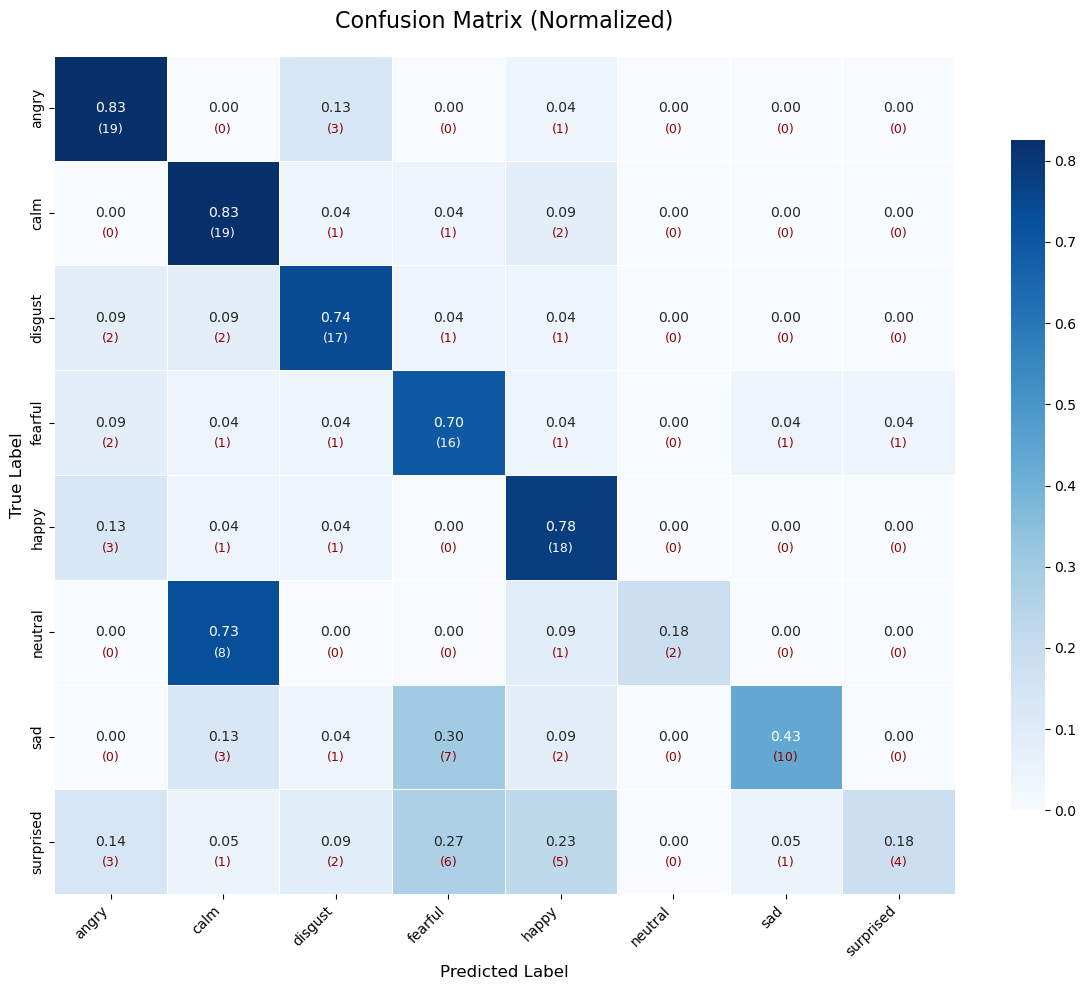

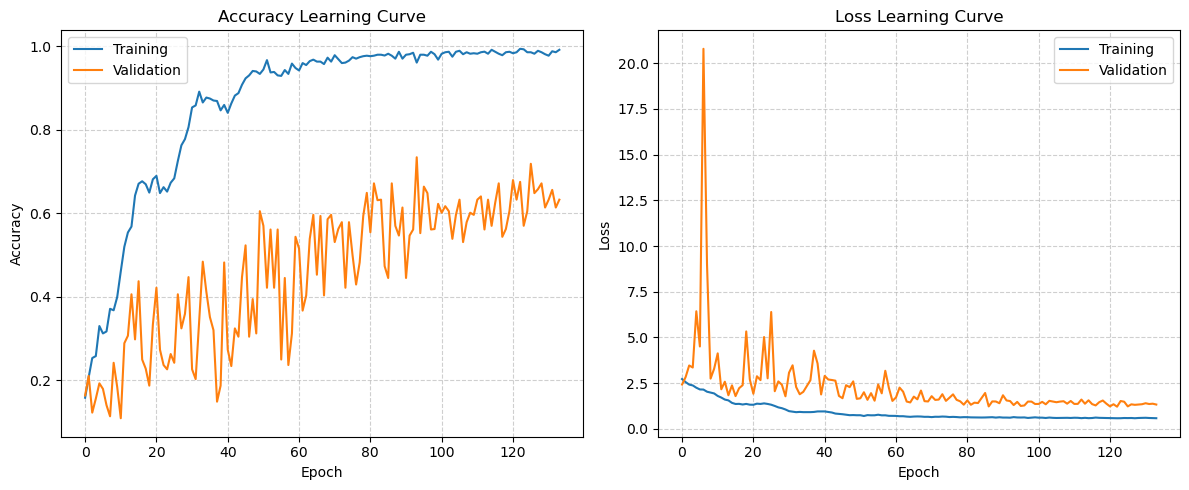

Enhanced model and preprocessing tools saved successfully!


In [19]:
# Create a detailed confusion matrix
def plot_detailed_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    
    # Plot the confusion matrix with better styling
    ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5, cbar_kws={"shrink": 0.8})
    
    # Add counts to the cells as well as percentages
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = plt.text(j + 0.5, i + 0.7, f"({cm[i, j]})", 
                           ha="center", va="center", color="darkred" if cm_normalized[i, j] < 0.5 else "white", 
                           fontsize=9)
    plt.title('Confusion Matrix (Normalized)', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix_detailed.png')
    plt.show()

# Plot the detailed confusion matrix
plot_detailed_confusion_matrix(y_true, y_pred, label_encoder.classes_)

# 3. Add a learning curve plot to see training progress
plt.figure(figsize=(12, 5))

# Plot accuracy learning curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot loss learning curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

# Save model artifacts
model.save('improved_emotion_recognition_model.h5')

with open('feature_normalizer.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Enhanced model and preprocessing tools saved successfully!")
